# Classifier Performance with Adversarial Samples

In this notebook, we create some adversarial samples of a dataset using the Fast Gradient Sign Method (FSGM) and show the performance of several different classifier models when evaluated on these samples. In order to demonstrate the generalization of adversarial samples, we construct them using a completely separate dataset than what is used to train the classifier models. This is to follow the scenario where an adversarial will not have explicit access to a model's paramaters or the exact data it was trained on.

### Fast Gradient Sign Method

The Fast Gradient Sign Method (FGSM) is an algorithm to produce adversarial samples by adding small changes to pre-existing samples from a classification dataset. These small changes are usually imperceptable to the human eye, but can cause the output of a deep learning model to change enough to alter class predictions. In order to compute which small changes will result in the greatest skew in model outputs, FGSM uses gradient information from the loss on a classifier model that was trained on the type of data to be altered. The FGSM therefore requires two things; a representative dataset that mirrors the data used for any models that will be attacked, and a model trained on this representative dataset.

When training a deep learning model, backpropagation relies on the fact that the gradient of the loss function w.r.t model parameters is the multi-dimensional direction in model paramater space corresponding to the greatest increase of loss. Backpropagation therefore updates model paramaters in the exact opposite direction of this gradient in order to decrease the loss each update step. For FGSM, we compute the gradient of the loss w.r.t the input sample instead, resulting in the multi-dimensional direction in the input space that corresponds to the greates increase of loss. Since the goal of FGSM is to construct a sample that *hurts* the performance of the model (i.e. *increasing* the loss), this gradient information is used directly to slightly alter the input sample, resulting in a large increase of loss after this error cascades through the model undergoing multiple layers of multiplicative computation.

Given a trained classifier $f$, with input $x$, and loss function $L(f(x))$, the FGSM computes an adversarial sample $x_{adv}$ with the formula:

\begin{align}
x_{adv} = x + \epsilon * \text{sgn}(\nabla_x L(f(x)))
\tag{1}
\label{eq:fgsm}
\end{align}

Where $\epsilon$ is a small (strength indicator) number (i.e. 0.1) and the *sign* of the gradient is used instead of the actual gradient since this preserves enough information to be effective.  

### Friendly Classifier Models

We evaluate the performance of several friendly classifier models on adversarial samples in order to observe how different training/regularization methods defend against an adversarial attack. These models are listed according to their class names (located within the `model` directory of this project) and described below.

1. `VanillaClassifier`: 

    A control model. It is just a regular classifier trained on unaltered data samples with cross entropy loss. 
    

2. `AdversarialClassifier`: 

    A classifier trained on adversarial data samples with cross entropy loss. Adversarial samples are computed using a new pretrained *adversarial* classifier (different than the one used in this notebook and trained on the same "friendly* dataset partitions. The pretrained *adversarial* classifier is used to perform FGSM on samples prior to handing them to the classifier model for training.
    

3. `SuppressedClassifier`:

4. `SmoothClassifier`:


### Setup Dataset and Models

Since FGSM needs a dataset and a model trained on this dataset to compute adversarial samples, we create two independent paritions of our training data prior to training models for this project; one parition is used to provide the gradient information to FGSM when creating adversarial samples, and the other is used to train the remaining "friendly" classifier models, which are then evaluated on adversarially altered data from the test set. This setup ensures that our friendly models cannot pick up on any common dataset artifacts to defend against adversarial samples, since these samples are coinstructed using information from a completely disjoint dataset.

In the following code block we initialize a test set dataloader and load all models. You will have to alter the global variables `CONFIG`, `ADVERSARIAL_MODEL`, and `FRIENDLY_MODEL_DIR` to match locations and specifications for your local machine.

In [1]:
import torch
import torchvision
import glob
import numpy as np

from util.pytorch_utils import build_image_dataset
from util.data_utils import generate_df_from_image_dataset, graph_inputs_with_predictions
from module.classifier import Classifier

# local/model/data parameters
config = {
    'dataset_directory': '/home/dylan/datasets/cifar_png/',
    'batch_size': 32,
    'input_dimensions': (32, 32, 3),
    'number_workers': 1,
    'label_dict': {
        0: 'airplane',
        1: 'automobile',
        2: 'bird',
        3: 'cat',
        4: 'deer',
        5: 'dog',
        6: 'frog',
        7: 'horse',
        8: 'ship',
        9: 'truck'
    }
}

# local file locations
adversary_model_file = \
    '/home/dylan/trained_model_files/pytorch/adversarial_project/adversarial_models/classifier.pt'
fiendly_model_directory = '/home/dylan/trained_model_files/pytorch/adversarial_project/friendly_models/'

# get local device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# generate filenames/labels df from image data directory
data_dict = generate_df_from_image_dataset(config['dataset_directory'])

# add number of classes in labels to config
config['output_dimension'] = data_dict['train']['Label'].nunique()

# add number of samples to config
config['number_test'] = len(data_dict['test'])

# build testing dataloader
test_set, test_loader = build_image_dataset(
    data_dict['test'],
    image_size=config['input_dimensions'][:-1],
    batch_size=config['batch_size'],
    num_workers=config['number_workers']
)

# initialize and load adversarial model
adv_classifier = Classifier(config['input_dimensions'], config['output_dimension'])
adv_classifier.load_state_dict(torch.load(adversary_model_file, map_location=device))

# get all friendly model files
friendly_model_files = glob.glob(fiendly_model_directory+'*.pt')

# initialize all models found in friendly model directory
classifiers = [{
    'model_file': model_file,
    'name': model_file.split('/')[-1].strip('.pt'), 
    'model': Classifier(config['input_dimensions'], config['output_dimension'])
} for model_file in friendly_model_files]

# load all models found in friendly model directory
for classifier in classifiers:
    classifier['model'].load_state_dict(torch.load(classifier['model_file'], map_location=device))
    
# define cross entropy loss (requires logits as outputs)
loss_fn = torch.nn.CrossEntropyLoss()

### Quick FGSM Visualization

In this section, we grab a few dataset samples and directly visualize how altering adversarially changes their structure and the coorresponding predictions when provided to a classifier model. 

#### 1. Grab a batch of dataset samples:

In [2]:
# get a batch from the test loader and keep only first 4 samples
batch = iter(test_loader).next()
inputs = batch['image'][:4].to(device)
labels = batch['label'][:4].to(device)

# require gradient for input data (need to do this to compute the gradients
# for inputs dutring backward() call)
inputs.requires_grad = True

#### 2. Make adversarial samples:

In [3]:
# compute model outputs on test batch
outputs = adv_classifier(inputs)

# compute loss on current test batch
loss = loss_fn(outputs, labels)

# compute gradients of loss on backward pass
loss.backward()

# get gradients of input data
grads = inputs.grad

# perturb input data using FGSM
adv_inputs = inputs + ((0.1) * torch.sign(grads))

# keep pixel vals within [-1, 1]
new_min, new_max = -1., 1.
old_min, old_max = torch.min(adv_inputs), torch.max(adv_inputs)
adv_inputs = (((adv_inputs - old_min) / (old_max - old_min)) * \
              (new_max - new_min)) + new_min

#### 3. Compute predictions on original input samples:

/home/dylan/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


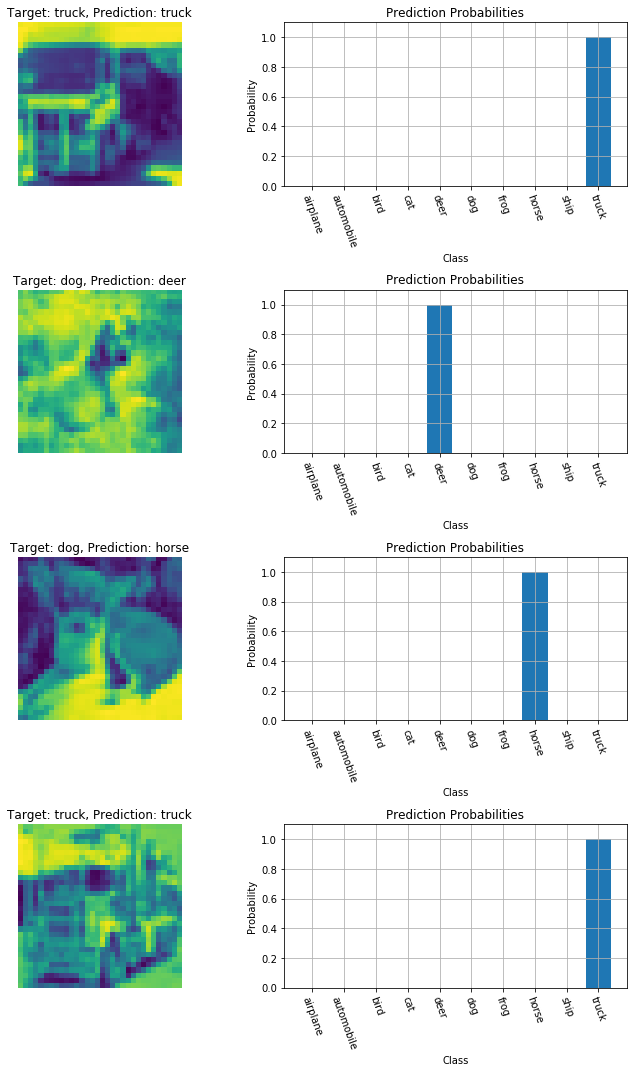

In [4]:
# get predictions
pred_prob = torch.nn.functional.softmax(outputs, dim=-1)
pred = torch.argmax(pred_prob, dim=-1)

# convert samples, labels, and prediction probabilities to numpy arrays
samples_np = np.transpose(inputs.cpu().detach().numpy(), [0, 2, 3, 1])
labels_np = labels.cpu().detach().numpy()
pred_prob_np = pred_prob.cpu().detach().numpy()
pred_np = pred.cpu().detach().numpy()

# plot the input samples with the corresponding class prediction probabilities
fig = graph_inputs_with_predictions(
    samples_np, 
    labels_np, 
    pred_prob_np, 
    pred_np, 
    figsize=(10, 15),
    label_dict=config['label_dict']
)
fig.show()

#### 4. Compute predictions on adversarial samples:

/home/dylan/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


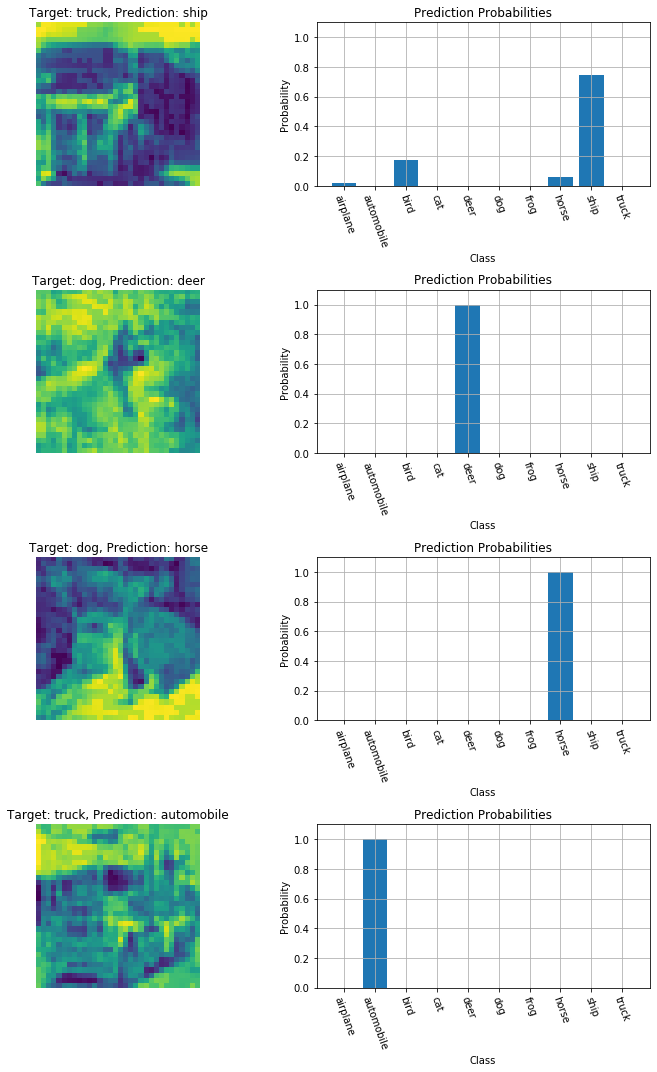

In [5]:
# get predictions on adversarial examples
adv_outputs = adv_classifier(adv_inputs)
adv_pred_prob = torch.nn.functional.softmax(adv_outputs, dim=-1)
adv_pred = torch.argmax(adv_pred_prob, dim=-1)

# convert samples, labels, and prediction probabilities to numpy arrays
adv_samples_np = np.transpose(adv_inputs.cpu().detach().numpy(), [0, 2, 3, 1])
adv_labels_np = labels.cpu().detach().numpy()
adv_pred_prob_np = adv_pred_prob.cpu().detach().numpy()
adv_pred_np = adv_pred.cpu().detach().numpy()

# plot the input samples with the corresponding class prediction probabilities
adv_fig = graph_inputs_with_predictions(
    adv_samples_np, 
    adv_labels_np,
    adv_pred_prob_np, 
    adv_pred_np, 
    figsize=(10, 15),
    label_dict=config['label_dict']
)
fig.show()

### Evaluate Models on Adversarial Samples with Varying Strengths

In the code block below, we sweep through a range of `epsilon` values to create adversarial samples of various strengths and test the performance of the friendly classifier models on these samples. 

**NOTE:** Running the code block below will take several minutes depending on your local systems performance.

In [6]:
# range of adversarial strengths 
start, stop, step = [0.0, 0.5, 0.05]
epsilon_range = np.arange(start, stop+step, step)

# create list entries to record classifier performance metrics
for classifier in classifiers:
    classifier['performance'] = {'epsilon': [],'accuracy': []}

# sweep adversarial strengh values of epsilon
for epsilon in epsilon_range:
    print('[INFO]: computing performance metrics on adversarial samples '\
          'with strength: {:.02f}'.format(epsilon))
    # initialize accumulators for each classifier
    for classifier in classifiers:
        classifier['num_correct'] = 0

    # run through epoch of test data
    for i, batch in enumerate(test_loader):
        # parse batch and move to training device
        input_batch = batch['image'].to(device)
        label_batch = batch['label'].to(device)

        # require gradient for input data (need to do this to compute the gradients 
        # for inputs dutring backward() call)
        input_batch.requires_grad = True

        # make adversarial samples from input batch
        adv_logits_batch = adv_classifier(input_batch)
        adv_loss = loss_fn(adv_logits_batch, label_batch)
        adv_loss.backward()
        adv_grads = input_batch.grad
        input_batch = input_batch + (epsilon * torch.sign(adv_grads))
        
        # keep pixel values in [-1, 1]
        new_min, new_max = -1., 1.
        old_min, old_max = torch.min(input_batch), torch.max(input_batch)
        input_batch = (((input_batch - old_min) / (old_max - old_min)) * \
                       (new_max - new_min)) + new_min

        for classifier in classifiers:
            # compute output batch logits and predictions
            logits_batch = classifier['model'](input_batch)
            pred_batch = torch.argmax(logits_batch, dim=1)

            # compute loss
            loss = loss_fn(logits_batch, label_batch)

            # accumulate number correct
            classifier['num_correct'] += torch.sum(
                (pred_batch == label_batch)
            ).item()

    # compute accuracy over epoch for current epsilon
    for classifier in classifiers:
        classifier['performance']['epsilon'].append(epsilon)
        classifier['performance']['accuracy'].append(
            100.0 * classifier['num_correct'] / config['number_test'])

[INFO]: computing performance metrics on adversarial samples with strength: 0.00


KeyboardInterrupt: 

In [ ]:
import plotly.graph_objects as go

data = [go.Scatter(
    x=classifier['performance']['epsilon'],
    y=classifier['performance']['accuracy'],
    name = classifier['name'],
    hoverinfo='x+y'
) for classifier in classifiers]

layout = go.Layout(
    title='Classifier Performance vs. Adversarial Attack Strength',
    xaxis={'title': 'epsilon'},
    yaxis={'title': 'accuracy (%)'},
    showlegend=True
)

fig = go.Figure(data=data, layout=layout)   
fig.show()